# Web crawling

In [ ]:
window.__SCRAPE_ABORT__?.abort();
window.__SCRAPE_ABORT__ = new AbortController();
const { signal } = window.__SCRAPE_ABORT__;

const DATE_TAG  = 'car_2016-2025';  
const BASE_PAUSE = 1200;       
const BETWEEN_BRAND = 2000;    

/* ====== 品牌清单（可增减/改顺序） ====== */
const BRANDS = [
    {slug:'POL',    names:['极星']},
    {slug:'GEN',    names:['捷尼赛思']},
    {slug:'ZEEKR',  names:['极氪']},
    {slug:'AITO',   names:['问界']},
    {slug:'AVATR',  names:['阿维塔']},
];

const START_BRAND_SLUG = ''; // 例：'ALDI'


const CITY_PLAN = [
  { abbr:'SH', path:['上海'] },
  { abbr:'HZ', path:['浙江','杭州'] },
  { abbr:'GZ', path:['广东','广州'] },
  { abbr:'SZ', path:['广东','深圳'] },
  { abbr:'BJ', path:['北京'] },
  { abbr:'NJ', path:['江苏','南京'] },
  { abbr:'CD', path:['四川','成都'] },
  { abbr:'CQ', path:['重庆'] },
  { abbr:'WH', path:['湖北','武汉'] },
];

const sleep = (ms, signal) => new Promise((res, rej)=>{
  const id = setTimeout(res, ms);
  signal?.addEventListener('abort', ()=>{ clearTimeout(id); rej(new DOMException('Aborted','AbortError')); }, {once:true});
});
async function waitFor(fn, timeout=7000, gap=120){
  const t0 = performance.now();
  while (performance.now()-t0 < timeout){
    const v = fn();
    if (v) return v;
    await sleep(gap, signal);
  }
  return null;
}
function humanClick(el){
  ['mouseover','mousedown','mouseup','click'].forEach(type=>{
    el.dispatchEvent(new MouseEvent(type, {bubbles:true, cancelable:true, view:window}));
  });
}
function pressEnter(target){
  const opt = {key:'Enter', code:'Enter', keyCode:13, which:13, bubbles:true, cancelable:true};
  target.dispatchEvent(new KeyboardEvent('keydown',  opt));
  target.dispatchEvent(new KeyboardEvent('keypress', opt));
  target.dispatchEvent(new KeyboardEvent('keyup',    opt));
}
function getChartContainer(){
  return document.querySelector('.index-trend-chart')
      || document.querySelector('[class*="index-trend-chart"]')
      || document.querySelector('[data-echarts-instance]')?.closest('div');
}
function getSearchInput(){
  // 站内搜索框（避免命中顶部全站搜索）
  return document.querySelector('.search-box form#search-input-form input.search-input')
      || document.querySelector('.search-input-form-container input.search-input')
      || document.querySelector('form#search-input-form input.search-input');
}
function getConfirmBtn(){
  const eq = t => /^确\s*定$/.test((t||'').trim());
  return [...document.querySelectorAll('.veui-button,button,span,div,a')]
    .find(el => el.offsetParent && eq(el.textContent));
}
function getSuggestItems(){
  const box = document.querySelector('.suggest-container');
  if (!box) return [];
  const visible = getComputedStyle(box).display !== 'none' && box.offsetParent !== null;
  if (!visible) return [];
  return [...box.querySelectorAll('li,div,span,a')].filter(el => el.offsetWidth>0 && el.offsetHeight>0);
}

async function setKeyword(word){
  const ipt = await waitFor(getSearchInput, 6000);
  if (!ipt){ console.log('wrong wards'); return false; }

  const chart = getChartContainer() || document;
  const before = (chart.textContent||'').length;

  ipt.focus();
  ipt.value = '';
  ipt.dispatchEvent(new InputEvent('input', {bubbles:true}));
  ipt.dispatchEvent(new CompositionEvent('compositionstart', {bubbles:true, data:''}));
  ipt.value = word;
  ipt.dispatchEvent(new InputEvent('input', {bubbles:true, data:word, inputType:'insertText'}));
  ipt.dispatchEvent(new CompositionEvent('compositionend', {bubbles:true, data:word}));
  await sleep(250, signal);

  // 2) 优先尝试回车
  [ipt, document, window].forEach(t => pressEnter(t));
  ipt.dispatchEvent(new Event('change', {bubbles:true}));
  ipt.blur();

  for (let i=0;i<16;i++){ // ~3s 观察
    await sleep(180, signal);
    if ((chart.textContent||'').length !== before) return true;
  }

  // 3) 回车无效 → 点击联想建议
  const items = getSuggestItems();
  if (items.length){
    const exact = items.find(el => (el.textContent||'').trim() === word)
               || items.find(el => (el.textContent||'').includes(word))
               || items[0];
    humanClick(exact);
    await sleep(250, signal);
  }

  // 4) 若出现“确定”，点击兜底
  const ok = getConfirmBtn();
  if (ok){ humanClick(ok); await sleep(350, signal); }

  // 5) 再观察曲线是否变化
  for (let i=0;i<20;i++){
    await sleep(200, signal);
    if ((chart.textContent||'').length !== before) return true;
  }

  console.log('enter is not accept / word undefine：', word, 'enter by hand after words input');
  return false;
}

/* ====== 抓当前图表 → 周一聚合 CSV ====== */
async function scrapeWeeklyCSV(filename){
  const container = getChartContainer();
  const canvas = container?.querySelector('canvas[data-zr-dom-id]') || container?.querySelector('canvas');
  if (!container || !canvas){ console.log('❌ graph can not find'); return false; }

  const rect = canvas.getBoundingClientRect();
  const centerY = rect.top + rect.height * 0.5;

  function readTooltip(){
    const tips = [...container.querySelectorAll('div')].filter(el=>{
      const s = getComputedStyle(el);
      return s.position==='absolute' && s.visibility!=='hidden' && +s.opacity>0 && /\d{4}-\d{2}-\d{2}/.test(el.textContent);
    }).sort((a,b)=>(parseFloat(getComputedStyle(b).zIndex)||0)-(parseFloat(getComputedStyle(a).zIndex)||0));
    const tip = tips[0]; if (!tip) return null;

    const txt = tip.textContent.replace(/\s+/g,' ').trim();
    const dm = txt.match(/(\d{4}-\d{2}-\d{2})/); if (!dm) return null;

    let val = null;
    for (const sp of tip.querySelectorAll('span')){
      const t = sp.textContent.trim();
      if (/^\d[\d,]*$/.test(t)){ val = t.replace(/,/g,''); break; }
    }
    if (val==null){ const m = txt.match(/(\d{1,3}(?:,\d{3})*|\d+)/g); if (m) val = m[m.length-1].replace(/,/g,''); }
    if (val==null) return null;

    return {dateStr: dm[1], index:+val};
  }

  const raw = new Map();
  const step = Math.max(2, Math.floor(rect.width/600));
  for (let x=rect.left+3; x<=rect.right-3; x+=step){
    if (signal.aborted) throw new DOMException('Aborted','AbortError');
    canvas.dispatchEvent(new MouseEvent('mousemove',{bubbles:true, clientX:x, clientY:centerY}));
    await sleep(8, signal);
    const tip = readTooltip();
    if (tip) raw.set(tip.dateStr, tip.index);
  }
  if (!raw.size){ console.log('tooltip not capture, move mouse'); return false; }

  const toMon = (ds)=>{ const d=new Date(ds), wd=d.getDay()||7, m=new Date(d); m.setDate(d.getDate()-(wd-1));
    const p=n=>n<10?'0'+n:''+n; return `${m.getFullYear()}-${p(m.getMonth()+1)}-${p(m.getDate())}`; };
  const wk = new Map();
  for (const [d,v] of raw.entries()){
    const k = toMon(d);
    wk.set(k, Math.max(wk.get(k)||0, v));
  }
  const rows = [...wk.entries()].sort((a,b)=>new Date(a[0])-new Date(b[0]));
  const csv  = 'date,index\n' + rows.map(([d,v])=>`${d},${v}`).join('\n');

  const blob = new Blob([csv], {type:'text/csv;charset=utf-8;'});
  const a = document.createElement('a');
  a.href = URL.createObjectURL(blob);
  a.download = filename;
  document.body.appendChild(a); a.click(); a.remove(); URL.revokeObjectURL(a.href);
  console.log('✅ download：', filename, ' week=', rows.length);
  return true;
}

/* ====== 自动切城市（直辖市一跳；省→市两跳） ====== */
function getRegionBtn(){
  // “浙江 - 杭州” 按钮
  return document.querySelector('.index-region button.veui-button')
      || document.querySelector('.index-region button');
}
function getRegionOverlay(){
  // 省市浮层
  const all = [...document.querySelectorAll('.index-province-city-overlay-box, .index-dropdown-list-overlay-box')];
  return all.find(el => getComputedStyle(el).display !== 'none') || null;
}
function visible(el){ return !!el && el.offsetParent !== null && getComputedStyle(el).display !== 'none'; }
function normText(t){ return (t||'').replace(/\u00a0/g,' ').replace(/\s+/g,' ').trim(); }
function isClickable(el){
  if (!el) return false;
  const s = getComputedStyle(el);
  return (el.tagName==='SPAN') && (s.cursor==='pointer' || +s.zIndex>=0);
}
function findOptionByText(root, text){
  const want = normText(text);
  const spans = [...root.querySelectorAll('span')].filter(isClickable);
  return spans.find(sp => normText(sp.textContent) === want)
      || spans.find(sp => normText(sp.textContent).includes(want))
      || null;
}
async function openRegion(){
  const btn = await waitFor(getRegionBtn, 6000);
  if (!btn) return null;
  if (!visible(getRegionOverlay())) { humanClick(btn); await sleep(200, signal); }
  return await waitFor(getRegionOverlay, 3000);
}
async function waitRegionLabel(path, timeout=4000){
  const btn = await waitFor(getRegionBtn, 3000);
  if (!btn) return false;
  const t0 = performance.now();
  while (performance.now()-t0 < timeout){
    const txt = normText(btn.textContent);
    if (path.every(p => txt.includes(p))) return true;
    await sleep(120, signal);
  }
  return false;
}
async function pickProvince(name){
  const overlay = await openRegion(); if (!overlay) return false;
  const provBox = overlay.querySelector('.provinces-box') || overlay;
  const el = findOptionByText(provBox, name);
  if (!el){ console.log('❌ 未找到省份：', name); return false; }
  el.scrollIntoView({block:'center'}); humanClick(el);
  await sleep(150, signal);
  return true;
}
async function pickCity(name){
  const overlay = await waitFor(getRegionOverlay, 2000);
  if (!overlay) return false;
  const cityBox = overlay.querySelector('.city-box') || overlay;
  const el = findOptionByText(cityBox, name);
  if (!el){ console.log('❌ 未找到城市：', name); return false; }
  el.scrollIntoView({block:'center'}); humanClick(el);
  await sleep(200, signal);
  // 选择后浮层会收起
  for (let i=0;i<20;i++){ if (!visible(getRegionOverlay())) break; await sleep(120, signal); }
  return true;
}
/** path 直辖市示例：['上海']；省会示例：['浙江','杭州'] */
async function setRegion(path){
  if (!Array.isArray(path) || !path.length) return false;
  const first = path[0], second = path[1];

  // 打开面板
  const overlay = await openRegion();
  if (!overlay){ console.log('❌ 打不开省市面板'); return false; }

  // 只有一段：直辖市 / 特区
  if (!second){
    const ok1 = await pickProvince(first);
    const ok2 = await waitRegionLabel([first], 3000);
    return ok1 && ok2;
  }

  // 两段：先省再市
  const okP = await pickProvince(first);
  if (!okP) return false;

  // 等城市列表出现
  await waitFor(()=> getRegionOverlay()?.querySelector('.city-box'), 3000);
  const okC = await pickCity(second);
  const okL = await waitRegionLabel([first, second], 3500);
  return okP && okC && okL;
}

/* ====== 主流程：按城市→按品牌 ====== */
(async ()=>{
  try{
    let brands = BRANDS.slice();
    if (START_BRAND_SLUG){
      const i = brands.findIndex(b=>b.slug===START_BRAND_SLUG);
      if (i>=0) brands = brands.slice(i);
    }

    for (const city of CITY_PLAN){
      if (signal.aborted) throw new DOMException('Aborted','AbortError');

      console.log('🗺 city switching：', city.path.join(' - '));
      const switched = await setRegion(city.path);
      if (!switched){ console.log('❌ city switching fail, skip：', city.path.join('-')); continue; }
      await sleep(300, signal); // 给图表一次刷新机会

      for (const b of brands){
        if (signal.aborted) throw new DOMException('Aborted','AbortError');

        const word = b.names[0];
        const file = `${b.slug}__${city.abbr}__${word}__${DATE_TAG}_week.csv`;

        const ok = await setKeyword(word);
        if (!ok){ console.log('❌ wrong word：', word); continue; }

        await sleep(BASE_PAUSE + Math.random()*600, signal);
        await scrapeWeeklyCSV(file);
        await sleep(BETWEEN_BRAND + Math.random()*1000, signal);
      }
    }

    console.log('🎉 all done');
  }catch(e){
    if (e.name==='AbortError') console.log('⛔ mannual abort');
    else console.error('❌ fail：', e);
  }
})();

# Part 0 get index_log

In [ ]:
# -*- coding: utf-8 -*-

from __future__ import annotations
import re
from pathlib import Path
import pandas as pd
import numpy as np

# === 1) 路径设置（按你的目录） ===
SUM_DIR = Path(r"...\car_2016-2025\sum")
OUT_DIR = Path(r"...\car_2016-2025")
OUT_FILE = OUT_DIR / "car_panel_sum_ready.csv"

# === 2) 城市与品牌映射（可按需补充/修改） ===
CITY_ABBR_TO_NAME = {
    "BJ": "北京", "SH": "上海", "GZ": "广州", "SZ": "深圳", "HZ": "杭州",
    "NJ": "南京", "WH": "武汉", "XA": "西安", "CD": "成都", "CQ": "重庆",
    "TJ": "天津", "CS": "长沙", "DL": "大连", "QD": "青岛", "XM": "厦门",
}

BRAND_SLUG_TO_ZH = {
"POL": "极星",
"GEN": "捷尼赛思",
"ZEEKR": "极氪",
"AITO": "问界",
"AVATR": "阿维塔",
}

# === 3) 兼容的文件名解析器 ===
# 方案 A（新）：WMT_BJ__沃尔玛_2023-2025_week.csv
PATTERN_A = re.compile(
    r"^(?P<brand>[A-Za-z0-9]+)_(?P<city>[A-Z]{2})__?(?P<brandzh>[^_]+)_.+?\.csv$"
)

# 方案 B（旧）：WMT__CN__沃尔玛_week_BJ_2023-2025.csv
PATTERN_B = re.compile(
    r"^(?P<brand>[A-Za-z0-9]+)__[A-Za-z0-9]+__?(?P<brandzh>[^_]+)_week_(?P<city>[A-Z]{2})_.+?\.csv$"
)

def parse_from_filename(fname: str) -> dict:
    """从文件名解析 brand_slug / city_abbr / brand_zh；失败则尽量从映射补齐。"""
    base = Path(fname).name
    m = PATTERN_A.match(base)
    if not m:
        m = PATTERN_B.match(base)

    brand_slug, city_abbr, brand_zh = None, None, None
    if m:
        brand_slug = (m.group("brand") or "").upper()
        city_abbr = (m.group("city") or "").upper()
        brand_zh = (m.group("brandzh") or "").strip()
    else:
        # 兜底：尝试从片段里找城市缩写
        up = base.upper()
        for abbr in CITY_ABBR_TO_NAME:
            if f"_{abbr}_" in up or up.endswith(f"_{abbr}.CSV"):
                city_abbr = abbr
                break
        # 尝试找品牌（字母连串）
        t = re.findall(r"[A-Za-z]{2,}", base)
        if t:
            brand_slug = t[0].upper()

    # 品牌中文名兜底映射
    if (not brand_zh) and brand_slug in BRAND_SLUG_TO_ZH:
        brand_zh = BRAND_SLUG_TO_ZH[brand_slug]

    return {
        "brand_slug": brand_slug,
        "city_abbr": city_abbr,
        "brand_zh": brand_zh,
    }

# === 4) 读取单个 CSV 并标准化列 ===
def load_one_csv(fp: Path) -> pd.DataFrame:
    """
    预期原始列：date,index（图一）
    转换：week_monday（datetime.date），index（int/float）
    并补充文件名信息列
    """
    try:
        df = pd.read_csv(fp, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(fp, encoding="gb18030")  # 兜底国标码

    # 兼容大小写/空白
    cols = {c.strip().lower(): c for c in df.columns}
    if "date" not in cols or "index" not in cols:
        raise ValueError(f"{fp.name} 缺少必需列：date / index")

    # 统一列名
    df = df.rename(columns={cols["date"]: "date", cols["index"]: "index"})

    # 解析日期 → 周一
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    # 如果原始就是“每周一”，直接用；否则把日期向前/向后对齐到该周周一
    # 这里假设是周一数据，不强行改动；如需强制周一：df["week_monday"] = df["date"] - pd.to_timedelta(df["date"].dt.weekday, unit="D")
    df["week_monday"] = df["date"].dt.date

    # 清洗 index
    df["index"] = pd.to_numeric(df["index"], errors="coerce")

    meta = parse_from_filename(fp.name)
    df["brand_slug"] = meta["brand_slug"]
    df["city_abbr"] = meta["city_abbr"]
    df["brand_zh"] = meta["brand_zh"]

    # 城市中文名
    df["city_name"] = df["city_abbr"].map(CITY_ABBR_TO_NAME)

    # 保留关键列
    keep = ["week_monday", "city_abbr", "brand_slug", "brand_zh", "city_name", "index"]
    df = df[keep]

    return df

# === 5) 合并主程序 ===
def main():
    if not SUM_DIR.exists():
        raise FileNotFoundError(f"输入目录不存在：{SUM_DIR}")
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    files = sorted([p for p in SUM_DIR.glob("*.csv") if p.is_file()])
    if not files:
        raise RuntimeError(f"未在 {SUM_DIR} 找到任何 CSV 文件。")

    parts = []
    bad = []
    for fp in files:
        try:
            dfi = load_one_csv(fp)
            parts.append(dfi)
        except Exception as e:
            bad.append((fp.name, str(e)))

    if not parts:
        raise RuntimeError("没有成功读取的 CSV。")

    panel = pd.concat(parts, ignore_index=True)

    # 丢弃元数据缺失的行
    panel = panel.dropna(subset=["week_monday", "index", "brand_slug", "city_abbr"]).copy()

    # 计算衍生列
    panel["index_log"] = np.where(panel["index"] > 0, np.log(panel["index"]), np.nan)

    # 按品牌x城市计算 z 分数（与图二一致的做法）
    def zscore(x: pd.Series) -> pd.Series:
        mu, sd = x.mean(), x.std(ddof=0)
        return (x - mu) / sd if sd and not np.isnan(sd) else pd.Series([np.nan] * len(x), index=x.index)

    panel["index_z"] = panel.groupby(["brand_slug", "city_abbr"], group_keys=False)["index"].apply(zscore)

    # 排序 & 去重
    panel = panel.sort_values(["brand_slug", "city_abbr", "week_monday"]).drop_duplicates(
        subset=["brand_slug", "city_abbr", "week_monday"], keep="last"
    )

    # 保存
    panel.to_csv(OUT_FILE, index=False, encoding="utf-8-sig")

    # 打印一些汇总信息
    brands = panel["brand_slug"].nunique()
    cities = panel["city_abbr"].nunique()
    rows = len(panel)
    rng_min = panel["week_monday"].min()
    rng_max = panel["week_monday"].max()

    print(f"✅ saved: {OUT_FILE}")
    print(f"rows: {rows} | brands: {brands} | cities: {cities} | range: {rng_min} → {rng_max}")

    if bad:
        print("\n以下文件读取失败（可检查列名/编码/文件名格式）：")
        for name, err in bad[:20]:
            print(f"  - {name}: {err}")
        if len(bad) > 20:
            print(f"  ... 以及 {len(bad)-20} 个更多")

if __name__ == "__main__":
    # 可选：提高显示精度
    pd.set_option("display.width", 160)
    pd.set_option("display.max_columns", 20)
    main()


✅ saved: C:\Users\vince\Desktop\eco 359\car_2016-2025\car_panel_sum_ready.csv
rows: 22569 | brands: 5 | cities: 9 | range: 2015-12-28 → 2025-10-20


c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Part 1 event_log

In [ ]:
# =========================
# Part 1  构面板 + 合并事件 + 生成 rel_week / rw_k （带兜底）
# =========================
import numpy as np, pandas as pd
from pathlib import Path

# 路径
ROOT = r"...\car_2016-2025"
PANEL_READY = Path(ROOT) / "panel_sum_ready.csv"
EVENT_LOG   = Path(ROOT) / "localization_events_auto_cn_eventlog.csv"
OUT_EVENTS  = Path(ROOT) / "panel_with_events.csv"   # 事件研究数据（含 rw_*）
OUT_TWFE    = Path(ROOT) / "panel_twfe.csv"          # 兜底：TWFE（ever-treated）

def read_csv_robust(p: Path):
    for enc in ("utf-8-sig","utf-8","gb18030","gbk"):
        try: return pd.read_csv(p, encoding=enc)
        except Exception: pass
    return pd.read_csv(p)

# 读面板
panel_ready = read_csv_robust(PANEL_READY)
panel_ready.columns = [c.strip().lower() for c in panel_ready.columns]
need_cols = {"week_monday","index","brand_slug","city_abbr"}
miss = need_cols - set(panel_ready.columns)
if miss: raise ValueError(f"panel_ready.csv 缺少列：{miss}")

panel_ready["brand_slug"]  = panel_ready["brand_slug"].astype(str).str.upper().str.strip()
panel_ready["city_abbr"]   = panel_ready["city_abbr"].astype(str).str.upper().str.strip()
panel_ready["week_monday"] = pd.to_datetime(panel_ready["week_monday"], errors="coerce")
panel_ready["index"]       = pd.to_numeric(panel_ready["index"], errors="coerce")

sample_start = panel_ready["week_monday"].min()
sample_end   = panel_ready["week_monday"].max()
print(f"[样本周范围] {sample_start.date()} → {sample_end.date()}")
print("[面板品牌数/城市数] ", panel_ready["brand_slug"].nunique(), "/", panel_ready["city_abbr"].nunique())

# 读事件
ev = read_csv_robust(EVENT_LOG)
ev.columns = [c.strip().lower() for c in ev.columns]
need_ev = {"brand_slug","city_scope","event_date"}
miss_ev = need_ev - set(ev.columns)
if miss_ev: raise ValueError(f"event_log.csv 缺少列：{miss_ev}")

ev["brand_slug"] = ev["brand_slug"].astype(str).str.upper().str.strip()
ev["event_date"] = pd.to_datetime(ev["event_date"], errors="coerce")
ev = ev.dropna(subset=["event_date"])

# city_abbr
if "city_abbr" not in ev.columns:
    ev["city_abbr"] = np.where(ev["city_scope"].astype(str).str.len()==2,
                               ev["city_scope"].astype(str).str.upper().str.strip(),
                               np.nan)
else:
    ev["city_abbr"] = ev["city_abbr"].astype(str).str.upper().str.strip()

# 展开 national
cities = panel_ready[["city_abbr"]].drop_duplicates()
ev_nat = ev[ev["city_scope"].astype(str).str.lower().eq("national")].copy()
if len(ev_nat):
    ev_nat = ev_nat.merge(cities, how="cross")
    ev_nat["city_abbr"] = ev_nat["city_abbr_y"]
    ev_nat = ev_nat.drop(columns=[c for c in ev_nat.columns if c.endswith("_y")])

ev_loc = ev[~ev["city_scope"].astype(str).str.lower().eq("national")].copy()
ev_loc = ev_loc.dropna(subset=["city_abbr"])
ev_all = pd.concat([ev_nat, ev_loc], ignore_index=True)

print("[事件条数（原始）] ", len(ev_all))
print("[事件时间范围] ", ev_all["event_date"].min().date(), "→", ev_all["event_date"].max().date())

# -------- 参数 ----------
K = 20           # 事件研究窗口（±K 周）
K_BUF = 104      # 允许事件相对样本的缓冲（先用较大值定位）
# -----------------------

# 仅保留落在样本±K_BUF周的事件（调大/调小取决于你的数据覆盖）
mask_time = (ev_all["event_date"] >= sample_start - pd.Timedelta(weeks=K_BUF)) & \
            (ev_all["event_date"] <= sample_end   + pd.Timedelta(weeks=K_BUF))
print(f"[事件条数] 样本±{K_BUF}周内：{mask_time.sum()} / {len(ev_all)}")
ev_sub = ev_all.loc[mask_time].copy()

# 合并（先不筛窗口）
m = panel_ready.merge(
    ev_sub[["brand_slug","city_abbr","event_date","event_type"]],
    on=["brand_slug","city_abbr"], how="left", indicator=True
)
print(f"[merge 命中率] {(m['event_date'].notna().mean()):.2%}")
print(m["_merge"].value_counts())

# 计算 rel_week
ev_week = m["event_date"].dt.to_period("W-MON").dt.start_time
m["rel_week"] = ((m["week_monday"] - ev_week) / pd.Timedelta(weeks=1)).round()

# 选择最近事件
m["abs_rel"] = m["rel_week"].abs()
m = (m.sort_values(["brand_slug","city_abbr","week_monday","abs_rel"])
       .drop_duplicates(subset=["brand_slug","city_abbr","week_monday"], keep="first"))

print("[rel_week 非空占比] ", m["rel_week"].notna().mean())
print("[rel_week 原始范围] ", m["rel_week"].min(), "→", m["rel_week"].max())

# ===== 正常路径：样本内存在事件 → 事件研究数据 =====
df_evt = m[m["rel_week"].notna()].copy()
df_evt["rel_week"] = df_evt["rel_week"].astype(int)
df_evt = df_evt[df_evt["rel_week"].between(-K, K)].copy()

if len(df_evt) > 0:
    # 生成 rw_k（排除 baseline=-1）
    old = [c for c in df_evt.columns if c.startswith("rw_")]
    if old: df_evt = df_evt.drop(columns=old)
    for k in range(-K, K+1):
        if k == -1: continue
        df_evt[f"rw_{k}"] = (df_evt["rel_week"] == k).astype("float64")

    df_evt.to_csv(OUT_EVENTS, index=False, encoding="utf-8-sig")
    print("✅ 事件研究数据已保存：", OUT_EVENTS)
    print("窗口覆盖：", df_evt["rel_week"].min(), "→", df_evt["rel_week"].max())
    print("动态变量个数：", len([c for c in df_evt.columns if c.startswith("rw_")]))
else:
    # ===== 兜底路径：样本内没有事件 → 做 TWFE（ever-treated） =====
    # 对每个 brand×city 取“最早事件日期”（哪怕不在样本内）
    ev_earliest = (ev_all.dropna(subset=["city_abbr"])
                         .sort_values(["brand_slug","city_abbr","event_date"])
                         .drop_duplicates(subset=["brand_slug","city_abbr"], keep="first")
                         .rename(columns={"event_date":"first_event"}))

    tw = panel_ready.merge(ev_earliest[["brand_slug","city_abbr","first_event"]],
                           on=["brand_slug","city_abbr"], how="left")

    tw["treated"]   = tw["first_event"].notna().astype("int8")  # 是否“曾经被处理过”
    tw["post_any"]  = (tw["treated"].eq(1) &
                       (tw["week_monday"] >= tw["first_event"].dt.to_period("W-MON").dt.start_time)
                      ).astype("int8")  # 样本内是否处于“事件之后”的长期阶段

    # 保存给 Part 2：两向 FE 的 TWFE 回归： y ~ post_any  + FE(bc) + FE(week)，聚类到 bc
    tw.to_csv(OUT_TWFE, index=False, encoding="utf-8-sig")
    print("⚠️ 样本期内没有任何事件窗口可做事件研究。已生成 TWFE 数据：", OUT_TWFE)
    print("   - treated=1 的品牌城市：", int(tw["treated"].sum()),
          "（这些在样本期内 post_any 可能恒为 1；识别来自与 treated=0 的对比）")
    print("   - 建议：扩展周度数据到最早事件前 ≥K 周，例如：",
          (ev_all['event_date'].min() - pd.Timedelta(weeks=K)).date(), "之前。")


[样本周范围] 2015-12-28 → 2025-10-20
[面板品牌数/城市数]  5 / 9
[事件条数（原始）]  54
[事件时间范围]  2013-12-16 → 2022-12-20
[事件条数] 样本±104周内：45 / 54
[merge 命中率] 72.59%
_merge
both          23085
left_only      8718
right_only        0
Name: count, dtype: int64
[rel_week 非空占比]  0.613717931676193
[rel_week 原始范围]  -364.0 → 209.0
✅ 事件研究数据已保存： C:\Users\vince\Desktop\eco 359\car_2016-2025\panel_with_events.csv
窗口覆盖： -20 → 20
动态变量个数： 40


# Part 2 Staggered DID TWFE

[Kept bins] ['at_0', 'lag_1_5', 'lag_6_10', 'lead_10_6', 'lead_5_2'] | rows=522 | events=27 | clusters(bc)=27
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.204e+14
Date:                Thu, 13 Nov 2025   Prob (F-statistic):          7.53e-177
Time:                        00:28:01   Log-Likelihood:                 150.09
No. Observations:                 522   AIC:                            -88.18
Df Residuals:                     416   BIC:                             363.1
Df Model:                         105                                         
Covariance Type:              cluster                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-

c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 115, but rank is 23
  warnings.warn('covariance of constraints does not have full '
c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Wild-cluster bootstrap p-values: {'at_0': 0.4795, 'lag_1_5': 0.5135, 'lag_6_10': 0.4995, 'lead_10_6': 0.5015, 'lead_5_2': 0.5115}


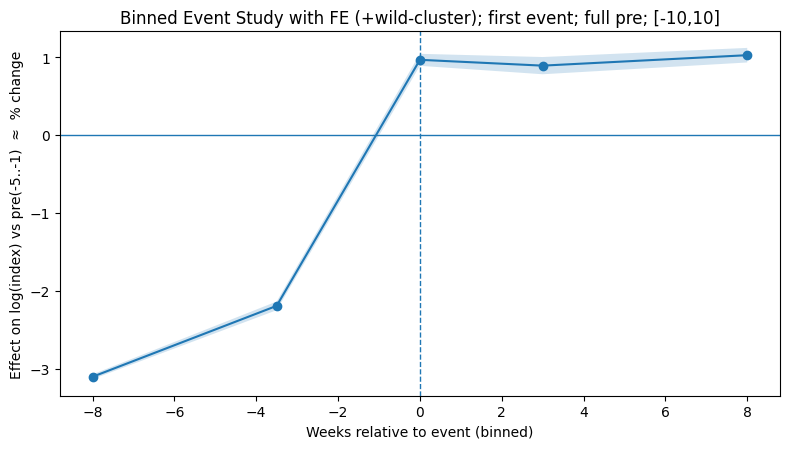


效应表（相对基准；聚类稳健与 wild-cluster p 并列）：
      bin   n    coef     se      pct  p_cluster  p_wild
lead_10_6 135 -3.1057 0.0156 -95.5209     0.0000  0.5015
 lead_5_2 108 -2.1951 0.0285 -88.8650     0.0000  0.5115
     at_0  27  0.9640 0.0393 162.2136     0.0000  0.4795
  lag_1_5 135  0.8892 0.0564 143.3204     0.0000  0.5135
 lag_6_10  90  1.0234 0.0478 178.2603     0.0000  0.4995


In [ ]:
# -*- coding: utf-8 -*-
"""
Event-study (binned) with stronger sample discipline + FE + wild-cluster bootstrap
- 仅保留首个事件；要求完整 [-5,-1] 预期窗口；窗口收紧到 [-10,10]
- 强制每个事件包含 week=0；对 at_0 放宽计数阈值
- 模型：y = log(index) - mean_{[-5,-1]} log(index) per (bc,event)
        y ~ bins + C(bc) + C(wk) [+ C(bc):tnum (+ C(bc):tnum2)]
- SE：按 bc 聚类；预趋势：lead_* 的联合 F 检验
- 额外：对各桶给 wild-cluster bootstrap p 值（Rademacher，按 bc 聚类）
"""

import numpy as np, pandas as pd, statsmodels.api as sm, patsy
import matplotlib.pyplot as plt
from pathlib import Path

# ===================== CONFIG =====================
ROOT = Path(r"...\car_2016-2025")
CSV  = ROOT / "panel_with_events.csv"

WINDOW = (-10, 10)          # 事件研究窗口
USE_TREND1 = True           # 单位线性趋势 C(bc):tnum
USE_TREND2 = False          # 单位二次趋势 C(bc):tnum2（需要时 True）

# 分桶（与基准[-5,-1]不重叠）
BINS = [
    ("lead_10_6",  (-10, -6)),
    ("lead_5_2",   ( -5,  -2)),
    ("at_0",        (  0,   0)),
    ("lag_1_5",     (  1,   5)),
    ("lag_6_10",    (  6,  10)),
]
MIN_COUNT_PRIMARY = 50      # 常规每桶样本下限
MIN_COUNT_FALLBK  = 20      # 退一步阈值
MIN_AT0           = 10      # at_0 单独放宽
BOOT_B = 999               # wild-cluster bootstrap 次数
RANDOM_SEED = 2025
# ==================================================

# ---------- Load ----------
df0 = pd.read_csv(str(CSV), low_memory=False)
df0["bc"] = (df0["brand_slug"].astype(str).str.upper() + "_" +
             df0["city_abbr"].astype(str).str.upper())
df0["wk"] = pd.to_datetime(df0["week_monday"]).dt.to_period("W-MON").astype(str)

# 仅保留有事件相对周的行（用于事件窗口）
df = df0[df0["rel_week"].notna()].copy()
df["rel_week"] = df["rel_week"].astype(int)

# ---------- (A) Sample discipline ----------
# A1) 每个 bc 仅保留“首个事件”
ev = (df[["bc","event_date"]].drop_duplicates()
        .sort_values(["bc","event_date"]))
first_ev = ev.groupby("bc", as_index=False).first().rename(columns={"event_date":"first_event_date"})
df = df.merge(first_ev, on="bc", how="left")
df = df[df["event_date"].eq(df["first_event_date"])].copy()

# A2) 要求完整的预期窗口 [-5,-1]
pre = df[df["rel_week"].between(-5, -1)]
complete = (pre.groupby(["bc","event_date"])["rel_week"]
              .nunique().reset_index(name="n_pre"))
good = complete[complete["n_pre"] == 5][["bc","event_date"]]
df = df.merge(good.assign(_keep=1), on=["bc","event_date"], how="left")
df = df[df["_keep"].eq(1)].drop(columns="_keep")

# A3) 限定分析窗口 [-10,10]
df = df[df["rel_week"].between(WINDOW[0], WINDOW[1])].copy()

# A4) ★ 强制包含 week=0（否则 at_0 会被门槛误删）
has0 = (df[df["rel_week"].eq(0)]
        .groupby(["bc","event_date"]).size().rename("has0"))
df = df.join(has0, on=["bc","event_date"])
df = df[df["has0"].fillna(0) > 0].drop(columns="has0")

# ---------- (B) Outcome: baseline-adjusted log ----------
log_idx = np.log(pd.to_numeric(df["index"], errors="coerce").clip(lower=1.0))
base = (df[df["rel_week"].between(-5, -1)]
        .assign(log_index=log_idx[df["rel_week"].between(-5, -1)].values)
        .groupby(["bc","event_date"])["log_index"].mean()
        .rename("y_base"))
df = df.join(base, on=["bc","event_date"]).dropna(subset=["y_base"]).copy()
df["y"] = np.log(pd.to_numeric(df["index"], errors="coerce").clip(lower=1.0)) - df["y_base"]

# ---------- (C) Bins ----------
for name, (lo, hi) in BINS:
    df[name] = df["rel_week"].between(lo, hi).astype("float64")

# 选择样本量足够的桶
keep = [n for n,_ in BINS if int(df[n].sum()) >= MIN_COUNT_PRIMARY] \
       or [n for n,_ in BINS if int(df[n].sum()) >= MIN_COUNT_FALLBK]
# at_0 单独放宽
if "at_0" not in keep and int(df["at_0"].sum()) >= MIN_AT0:
    keep = sorted(set(keep + ["at_0"]))
# 剔除全 0
keep = [c for c in keep if df[c].sum() > 0]

print(f"[Kept bins] {keep} | rows={len(df):,} | events={df[['bc','event_date']].drop_duplicates().shape[0]} | clusters(bc)={df['bc'].nunique()}")

# ---------- (D) FE + (optional) unit trends ----------
df["tnum"]  = pd.to_datetime(df["week_monday"]).factorize()[0].astype(float)
df["tnum2"] = df["tnum"]**2

fe_terms = "C(bc) + C(wk)"
if USE_TREND1:
    fe_terms += " + C(bc):tnum"
if USE_TREND2:
    fe_terms += " + C(bc):tnum2"

formula = f"y ~ {' + '.join(keep) if keep else '0'} + {fe_terms}"
y_mat, X_mat = patsy.dmatrices(formula, data=df, return_type="dataframe")

# ---------- (E) OLS with bc-clustered SE ----------
groups = df.loc[y_mat.index, "bc"]
res = sm.OLS(y_mat, X_mat).fit(cov_type="cluster", cov_kwds={"groups": groups})
print(res.summary())

# ---------- (F) Joint pre-trend F-test ----------
lead_cols = [c for c in keep if c.startswith("lead_")]
if lead_cols:
    idx = [X_mat.columns.get_loc(c) for c in lead_cols]
    R = np.zeros((len(idx), X_mat.shape[1])); R[np.arange(len(idx)), idx] = 1.0
    w = res.wald_test(R, use_f=True)
    print("Pre-trend joint F-test p-value:", float(w.pvalue))

# ---------- (G) Wild-Cluster Bootstrap p-values (per bin) ----------
def wild_cluster_pvals(y, X, clusters, cols, B=999, seed=2025):
    """
    Rademacher wild-cluster bootstrap (按 bc 聚类)：
    关键点：始终用 Pandas 的 DataFrame/Series 拟合，这样 params 带列名，
    解决 ndarray 不能用字符串索引导致的 IndexError。
    """
    import numpy as np, pandas as pd, statsmodels.api as sm

    # y -> Series，与 X 对齐
    y = pd.Series(np.asarray(y).ravel(), index=X.index)

    # 簇编码
    g_codes = pd.Series(clusters).astype("category").cat.codes.to_numpy()
    G = int(g_codes.max()) + 1

    rng = np.random.default_rng(seed)

    # 基准完整模型（用于取 β̂ 和列名）
    base_fit = sm.OLS(y, X).fit()
    beta_hat = base_fit.params  # 带列名的 Series

    pvals = {}
    for col in cols:
        # 受限模型：去掉 col，用其残差做 wild 权重
        X_r = X.drop(columns=[col])
        fit_r = sm.OLS(y, X_r).fit()
        mu_r = X_r @ fit_r.params           # Pandas Series
        resid_r = (y - mu_r).to_numpy()     # ndarray，便于逐元素乘权重

        boot_vals = np.empty(B)
        for b in range(B):
            # 簇级 Rademacher 权重
            w_g = rng.choice([-1.0, 1.0], size=G)
            w   = w_g[g_codes]              # 展开到观测
            y_star = mu_r.to_numpy() + resid_r * w
            y_star = pd.Series(y_star, index=X.index)  # 仍用 Series 拟合

            fit_b = sm.OLS(y_star, X).fit()            # 注意：X 不用 .values
            boot_vals[b] = fit_b.params[col]           # 现在可以用列名取参数

        # 双尾 p 值（H0: β=0）
        p = float(np.mean(np.abs(boot_vals) >= np.abs(beta_hat[col])))
        pvals[col] = max(1.0/B, p)  # 避免返回 0
    return pvals


wc_p = wild_cluster_pvals(y_mat, X_mat, groups, cols=[c for c in keep], B=BOOT_B, seed=RANDOM_SEED)
print("Wild-cluster bootstrap p-values:", {k: round(v,4) for k,v in wc_p.items()})

# ---------- (H) Table + Plot ----------
centers = {"lead_10_6":-8.0, "lead_5_2":-3.5, "at_0":0.0, "lag_1_5":3.0, "lag_6_10":8.0}
est = (pd.DataFrame({
        "bin": keep,
        "coef": [res.params.get(c, np.nan) for c in keep],
        "se":   [res.bse.get(c, np.nan)    for c in keep],
        "p_cluster": [res.pvalues.get(c, np.nan) for c in keep],
        "p_wild":    [wc_p.get(c, np.nan) for c in keep],
        "n":    [int(df[c].sum())          for c in keep],
    })
    .assign(k=lambda d: d["bin"].map(centers))
    .sort_values("k")
)
est["ci"]  = 1.96*est["se"]
est["pct"] = (np.exp(est["coef"]) - 1.0) * 100

plt.figure(figsize=(8,4.6))
plt.axhline(0, lw=1); plt.axvline(0, ls="--", lw=1)
plt.plot(est["k"], est["coef"], marker="o")
plt.fill_between(est["k"], est["coef"]-est["ci"], est["coef"]+est["ci"], alpha=0.2)
plt.xlabel("Weeks relative to event (binned)")
plt.ylabel("Effect on log(index) vs pre(-5..-1)  ≈  % change")
plt.title("Binned Event Study with FE (+wild-cluster); first event; full pre; [-10,10]")
plt.tight_layout(); plt.show()

print("\n效应表（相对基准；聚类稳健与 wild-cluster p 并列）：")
print(est[["bin","n","coef","se","pct","p_cluster","p_wild"]]
      .to_string(index=False, float_format=lambda x: f"{x:,.4f}"))


# Part 3 Staggered DID BJS

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# ---------------- 路径 ----------------
BASE = Path(r"...\car_2016-2025")
SUM_DIR   = BASE / "sum"
PANEL_SUM = BASE / "panel_sum_ready.csv"

# 事件表优先/回退候选（支持 csv/xlsx/.cvs）
EVENT_LOG_CANDIDATES = [
    BASE / "SDID_localization_events_auto_cn_eventlog.csv",
]

OUT_PWE   = BASE / "SDID_panel_with_events.csv"
OUT_ASYNC = BASE / "SDID_panel_async_ready.csv"

WINDOW_START = pd.Timestamp("2016-01-01")
WINDOW_END   = pd.Timestamp("2025-12-31")

# ---------- 小工具 ----------
def pick_first_existing(paths):
    hits = [p for p in paths if p.exists()]
    if hits:
        print(f"[事件表] 使用：{hits[0]}")
        return hits[0]
    print("[事件表] 未找到，目录下疑似文件：", [p.name for p in BASE.glob("*eventlog*")])
    raise FileNotFoundError("找不到事件表，请确认路径/文件名/扩展名。")

def map_degree(s: str) -> str:
    s = str(s).lower()
    if any(k in s for k in ["mixed", "both", "混合"]):         return "mixed"
    if any(k in s for k in ["semantic", "meaning", "意译"]):    return "semantic"
    if any(k in s for k in ["translit", "phonetic", "音译"]):   return "transliteration"
    if any(k in s for k in ["trademark", "商标"]):              return "trademark"
    if any(k in s for k in ["zh_name", "中文名", "命名"]):       return "zh_name_only"
    return "unknown"

def expand_scope(scope: str, all_cities: list) -> list:
    """ city_scope='national' -> 所有城市；支持 'BJ|SH,GZ'、'BJ,SH' 等 """
    if not isinstance(scope, str) or scope.strip()=="":
        return all_cities
    s = scope.strip().lower()
    if s == "national":
        return all_cities
    parts = [p.strip().upper() for p in s.replace(",", "|").split("|") if p.strip()]
    return [p for p in parts if p in all_cities] or all_cities

def parse_unit_from_filename(fname: str):
    """ 从 'ALDI_BJ_……_week.csv' 提取 brand_slug, city_abbr """
    base = Path(fname).stem
    # 先找类似 BRAND_CITY_ 的前两段
    segs = re.split(r"[_\s]+", base)
    if len(segs) >= 2:
        brand = segs[0].upper()
        city  = segs[1].upper()
        return brand, city
    return None, None

def coerce_date_col(df):
    # 常见候选：week_monday / date / 日期 / week / 周一
    cand = [c for c in df.columns if str(c).lower() in {"week_monday","date","week","monday"} or "日期" in str(c)]
    if not cand:
        raise ValueError("该 CSV 没有可识别的日期列。")
    c = cand[0]
    d = pd.to_datetime(df[c], errors="coerce")
    if d.notna().sum()==0:
        raise ValueError("日期列解析失败。")
    return d.rename("week_monday")

def coerce_index_cols(df):
    # 尝试寻找 index / value 列；若只有 index 则顺手生成 index_log/index_z
    # 常见候选名
    cand_val = [c for c in df.columns if str(c).lower() in {"index","value","bi","search","baidu"} or "指数" in str(c)]
    idx = None
    for c in ["index","Index"] + cand_val:
        if c in df.columns:
            idx = pd.to_numeric(df[c], errors="coerce")
            break
    if idx is None:
        # 退化：如果已有 index_log/index_z 就返回
        return (df.get("index"), df.get("index_log"), df.get("index_z"))
    idx_log = np.log(np.clip(idx, 1e-6, None))
    return idx, idx_log, None  # index_z 可后续再标准化

# ---------- 若 panel_sum_ready.csv 不在，则从 sum 合并 ----------
if not PANEL_SUM.exists():
    print("[合并] 未找到 panel_sum_ready.csv，开始从 sum/*.csv 合并…")
    frames = []
    for csvf in sorted(SUM_DIR.glob("*.csv")):
        try:
            tmp = pd.read_csv(csvf, encoding="utf-8-sig", low_memory=False)
        except Exception:
            tmp = pd.read_csv(csvf, low_memory=False)
        brand_slug, city_abbr = parse_unit_from_filename(csvf.name)
        if not brand_slug or not city_abbr:
            print(f"  [跳过] 文件名无法解析单位：{csvf.name}"); continue

        wk = coerce_date_col(tmp)
        idx, idx_log, idx_z = coerce_index_cols(tmp)
        # 可能含有中文名
        brand_zh  = tmp.get("brand_zh", np.nan)
        city_name = tmp.get("city_name", np.nan)

        out = pd.DataFrame({
            "week_monday": wk,
            "brand_slug":  brand_slug,
            "city_abbr":   city_abbr,
            "brand_zh":    brand_zh if len(brand_zh)==len(wk) else np.nan,
            "city_name":   city_name if len(city_name)==len(wk) else np.nan,
            "index":       idx,
            "index_log":   idx_log,
            "index_z":     idx_z,
        })
        frames.append(out)

    if not frames:
        raise RuntimeError("sum 目录下没有可用的 CSV，无法生成 panel_sum_ready.csv")

    panel = pd.concat(frames, ignore_index=True)
    panel = panel.dropna(subset=["week_monday","brand_slug","city_abbr"])
    panel["week_monday"] = pd.to_datetime(panel["week_monday"], errors="coerce")
    panel["unit"] = panel["brand_slug"].astype(str) + "_" + panel["city_abbr"].astype(str)
    panel.sort_values(["unit","week_monday"], inplace=True)
    panel.to_csv(PANEL_SUM, index=False, encoding="utf-8-sig")
    print(f"✅ 已生成：{PANEL_SUM}")
else:
    print(f"[合并] 发现现成的 panel_sum_ready.csv：{PANEL_SUM}")

# ---------------- 读入基础面板 ----------------
df = pd.read_csv(PANEL_SUM)
df.columns = [c.strip() for c in df.columns]

need = ["week_monday","brand_slug","city_abbr"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"panel_sum_ready.csv 缺少列：{missing}")

df["week_monday"] = pd.to_datetime(df["week_monday"], errors="coerce")
df["unit"] = df["brand_slug"].astype(str) + "_" + df["city_abbr"].astype(str)
all_cities = sorted(df["city_abbr"].dropna().unique().tolist())

# ---------------- 读入事件表（优先/回退） ----------------
EVENT_LOG = pick_first_existing(EVENT_LOG_CANDIDATES)
# 读取（csv/xlsx 自适应）
if EVENT_LOG.suffix.lower() == ".xlsx":
    ev = pd.read_excel(EVENT_LOG)
else:
    ev = pd.read_csv(EVENT_LOG, encoding="utf-8-sig")
ev.columns = [c.strip() for c in ev.columns]

for col in ["brand_slug","event_type","city_scope","event_date","event_name","source_url","notes","degree"]:
    if col not in ev.columns:
        ev[col] = np.nan

# 品牌别名对齐（与面板一致）
alias = {
    "AUCHAN": "AUCH",
    "METRO": "METR",
    "RTMART": "RTM",
    "COSTCO": "COST",
    "SAMS": "SAM", "SAM'S": "SAM", "SAM’S": "SAM",
}
ev["brand_slug"] = ev["brand_slug"].astype(str).str.upper().replace(alias)

# 仅取 2016–2025 窗口的事件
ev["event_date"] = pd.to_datetime(ev["event_date"], errors="coerce")
ev = ev[(ev["event_date"]>=WINDOW_START) & (ev["event_date"]<=WINDOW_END)].copy()

# 对齐到事件周的周一作为 treat_week
ev["treat_week"] = ev["event_date"] - pd.to_timedelta(ev["event_date"].dt.weekday, unit="D")

# 推断“程度”（若事件表没给）
if ev["degree"].isna().all():
    ev["degree"] = ev["event_type"].apply(map_degree)
else:
    ev["degree"] = ev["degree"].fillna(ev["event_type"].apply(map_degree))

# 展开 city_scope -> brand×city
rows = []
for _, r in ev.dropna(subset=["brand_slug","treat_week"]).iterrows():
    cities = expand_scope(r.get("city_scope","national"), all_cities)
    for abbr in cities:
        rows.append({
            "brand_slug": r["brand_slug"],
            "city_abbr":  abbr,
            "treat_week": r["treat_week"],
            "event_date": r["event_date"],
            "event_type": r.get("event_type", np.nan),
            "degree":     r.get("degree", "unknown"),
            "event_name": r.get("event_name", np.nan),
            "source_url": r.get("source_url", np.nan),
            "notes":      r.get("notes", np.nan),
        })
ev_exp = pd.DataFrame(rows)

# ---------------- 生成 SDID_panel_with_events.csv ----------------
pwe = df.merge(ev_exp, on=["brand_slug","city_abbr"], how="left")
pwe["rel_week"] = ((pwe["week_monday"] - pwe["treat_week"]).dt.days // 7) \
                    .where(pwe["treat_week"].notna(), pd.NA).astype("Int64")

cols_pwe = [
    "week_monday","brand_slug","brand_zh","city_abbr","city_name",
    "index","index_log","index_z",
    "event_date","treat_week","rel_week",
    "event_type","degree","event_name","source_url","notes",
    "unit"
]
cols_pwe = [c for c in cols_pwe if c in pwe.columns]
pwe_out = pwe.sort_values(["unit","week_monday"])[cols_pwe]
pwe_out.to_csv(OUT_PWE, index=False, encoding="utf-8-sig")
print(f"✅ 已导出：{OUT_PWE}")

# ---------------- 生成 SDID_panel_async_ready.csv ----------------
df2 = pwe.copy()

# 对同一 unit：仅保留“窗口内最早一次” treat_week
cohort_inwin = (ev_exp.sort_values("treat_week")
                      .groupby(["brand_slug","city_abbr"], as_index=False)
                      .first()[["brand_slug","city_abbr","treat_week"]])
df2 = df2.merge(cohort_inwin, on=["brand_slug","city_abbr"], how="left", suffixes=("","_inwin"))
df2["treat_week"] = df2["treat_week_inwin"].where(df2["treat_week_inwin"].notna(), df2["treat_week"])
df2.drop(columns=[c for c in ["treat_week_inwin"] if c in df2.columns], inplace=True)

# rel_week_async / bucket / treated_it / ever_treated
def to_bucket(x, lo=-20, hi=20):
    if pd.isna(x): return pd.NA
    x = int(x)
    return lo if x < lo else (hi if x > hi else x)

df2["rel_week_async"] = ((df2["week_monday"] - df2["treat_week"]).dt.days // 7) \
                         .where(df2["treat_week"].notna(), pd.NA).astype("Int64")
df2["relw_bucket"] = df2["rel_week_async"].apply(lambda x: to_bucket(x, -20, 20)).astype("Int64")
df2["treated_it"]   = ((df2["treat_week"].notna()) & (df2["week_monday"] >= df2["treat_week"])).astype(int)
df2["ever_treated"] = df2["treat_week"].notna().astype(int)

# 因变量 y：优先 index_log -> index_z -> index(log)
ycol = None
for c in ["index_log","index_z","index"]:
    if c in df2.columns:
        ycol = c; break
if ycol is None:
    raise ValueError("未找到因变量列：缺少 index / index_log / index_z")

if ycol == "index":
    df2["index_log"] = np.log(np.clip(pd.to_numeric(df2["index"], errors="coerce"), 1e-6, None))
    ycol = "index_log"

df2["y"] = pd.to_numeric(df2[ycol], errors="coerce")
df2["y_z_global"] = (df2["y"] - df2["y"].mean()) / (df2["y"].std(ddof=0) if df2["y"].std(ddof=0)!=0 else 1)
df2["y_z_by_unit"] = df2.groupby("unit")["y"].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0)!=0 else 1))

out_cols = [
    "week_monday","brand_slug","brand_zh","city_abbr","city_name",
    "index","index_log","index_z","y","y_z_global","y_z_by_unit",
    "treat_week","rel_week_async","relw_bucket","treated_it","ever_treated",
    "unit","degree","event_type"
]
out_cols = [c for c in out_cols if c in df2.columns]
async_out = df2.sort_values(["unit","week_monday"])[out_cols]
async_out.to_csv(OUT_ASYNC, index=False, encoding="utf-8-sig")
print(f"✅ 已导出：{OUT_ASYNC}")

# --------- 简要诊断 ---------
print({
    "rows": len(async_out),
    "units": async_out["unit"].nunique(),
    "brands": async_out["brand_slug"].nunique(),
    "cities": async_out["city_abbr"].nunique(),
    "time_range": f"{async_out['week_monday'].min()} → {async_out['week_monday'].max()}",
    "ever_treated_units": int(async_out.loc[async_out.get('ever_treated',0)==1,'unit'].nunique()) if 'ever_treated' in async_out.columns else None
})


[合并] 发现现成的 panel_sum_ready.csv：C:\Users\vince\Desktop\eco 359\car_2016-2025\panel_sum_ready.csv
[事件表] 使用：C:\Users\vince\Desktop\eco 359\car_2016-2025\SDID_localization_events_auto_cn_eventlog.csv
✅ 已导出：C:\Users\vince\Desktop\eco 359\car_2016-2025\SDID_panel_with_events.csv
✅ 已导出：C:\Users\vince\Desktop\eco 359\car_2016-2025\SDID_panel_async_ready.csv
{'rows': 22569, 'units': 44, 'brands': 5, 'cities': 9, 'time_range': '2015-12-28 00:00:00 → 2025-10-20 00:00:00', 'ever_treated_units': 44}



[诊断] 面板中的品牌数：5；有 treat_week 的品牌数：5
[诊断] 各品牌：受治单元数(≈城市数)、pre 样本数（受治前周次）:
            treated_units  pre_obs
brand_slug                        
POL                  3953     1697
GEN                  2187       36
ZEEKR                2142      252
AVATR                2094      753
AITO                 1818       99

[自适应窗口] 采用 K_POST=(1, 12)；期望展示 ≤7 个品牌，实际可纳入：5
[诊断] 该窗内各品牌优先级（n=窗口内样本数，ks=支持的 k 数）：
            ks    n
brand_slug         
AITO        12  108
AVATR       12  108
GEN         12  108
ZEEKR       12  108
POL         12   96


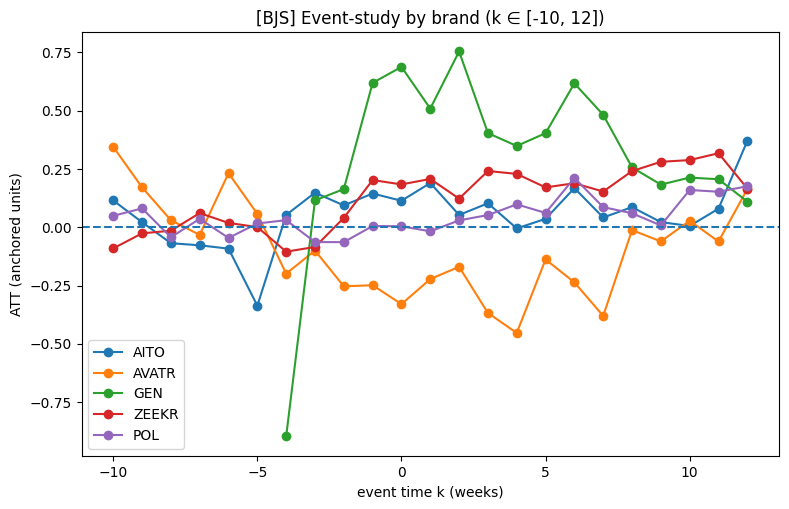

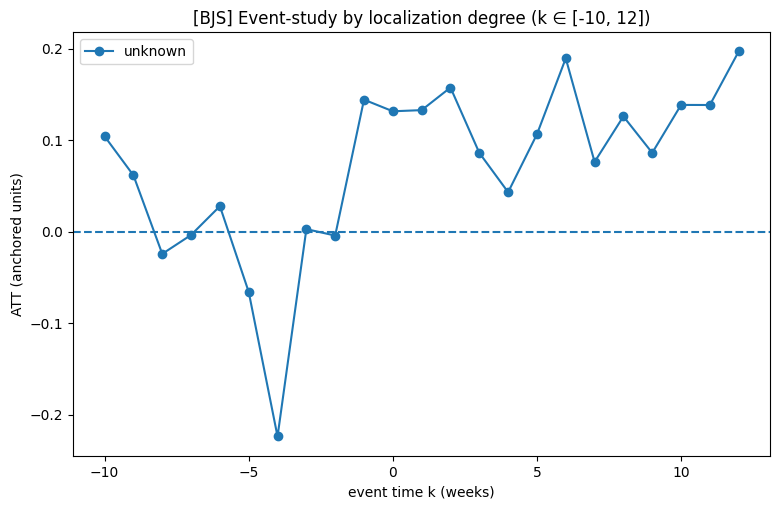


=== [BJS] Brand ranking by post-window average effect (anchored) ===
brand_slug  ATT_[1,12]  cohorts_used  obs_in_window  degree
       GEN    0.373578           1.0          108.0 unknown
     ZEEKR    0.216914           1.0          108.0 unknown
      AITO    0.095630           1.0          108.0 unknown
       POL    0.089577           1.0           96.0 unknown
     AVATR   -0.159306           1.0          108.0 unknown

[提示] 目前仅纳入 5 个品牌，未纳入的品牌：

[未纳入原因诊断]
Empty DataFrame
Columns: [brand, has_treat, has_pre, has_obs_in_window, units]
Index: []

改进路线：
1) 确认这些品牌是否真的在面板中存在（panel_sum_ready/SDID_panel_async_ready 是否有该 brand_slug）；
2) 若存在，检查 event_log 的 event_date 是否在 2016–2025 内，并已按 national 展开到全部城市；
3) 若 pre 样本不足，可把 PRE_WINDOW 放宽，比如 (-12,-1)，或下调 SPLINE_DF（如 6）；
4) 如仍不足，可把 CANDIDATE_WINDOWS 放宽，比如 (1,16)。


In [ ]:
# -*- coding: utf-8 -*-
# ============================================================
# Staggered DID (BJS 插补 + 事件研究·诊断增强版)
# 关键升级：
# 1) 以 pre-window 基准化：ATT_k = (y - ŷ) - mean_pre
# 2) 同时展示 pre 与 post，检视并行趋势
# 3) cohort 级别自助法（bootstrap）生成 95% CI
# 4) post 窗口内的品牌排名基于锚定效应
# 读取：SDID_panel_async_ready.csv / SDID_panel_with_events.csv
# 图表&表格只在 cell 中显示；不落盘
# ============================================================

import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from patsy import dmatrix
import statsmodels.api as sm

# ------------------ 路径与主要参数 ------------------
BASE = Path(r"...\car_2016-2025")
ASYNC = BASE / "SDID_panel_async_ready.csv"
PWE   = BASE / "SDID_panel_with_events.csv"

# 会自动在 y 与 y_z_by_unit 间选择覆盖度更高的一个
PREFERRED_Y_ORDER = ["y", "y_z_by_unit"]

# 预/后窗设置（pre 用于锚定；post 用于排名与窗口选择）
PRE_WINDOW        = (-10, -1)
CANDIDATE_WINDOWS = [(1,12),(1,10),(1,8),(1,6),(1,5),(1,4),(1,3),(1,2)]
TARGET_BRANDS     = 7      # 期待展示的品牌数量上限
MIN_K_PER_BRAND   = 1      # 每个品牌在后窗内至少需要多少个 k
SPLINE_DF         = 8      # 时间样条自由度（过大易抖动；6~10较稳）
BOOT_B            = 399    # cohort 级别 bootstrap 次数（可调大）
SEED              = 2025   # 随机种子
to_pct            = False  # 若 y 为对数，设 True 则把 ATT 显示为百分比（图注会追加 %）

rng = np.random.default_rng(SEED)

# ------------------ 读取与基础清洗 ------------------
df = pd.read_csv(ASYNC, parse_dates=["week_monday","treat_week"])
df.columns = [c.strip() for c in df.columns]
if "unit" not in df.columns:
    df["unit"] = df["brand_slug"].astype(str) + "_" + df["city_abbr"].astype(str)

# 回填/统一 degree（防止 degree 列名后缀冲突）
try:
    pwe = pd.read_csv(PWE)
    pwe.columns = [c.strip() for c in pwe.columns]
    if "unit" not in pwe.columns and {"brand_slug","city_abbr"}.issubset(pwe.columns):
        pwe["unit"] = pwe["brand_slug"].astype(str) + "_" + pwe["city_abbr"].astype(str)
    if "degree" in pwe.columns:
        deg_df = pwe[["unit","degree"]].drop_duplicates("unit")
        df = df.merge(deg_df, on="unit", how="left", suffixes=("", "_from_pwe"))
        if "degree_from_pwe" in df.columns:
            if "degree" in df.columns:
                df["degree"] = df["degree"].fillna(df["degree_from_pwe"])
            else:
                df["degree"] = df["degree_from_pwe"]
            drop_cols = [c for c in df.columns if c.endswith("_from_pwe")]
            if drop_cols: df.drop(columns=drop_cols, inplace=True)
    df["degree"] = df.get("degree", pd.Series(index=df.index, dtype=object)).fillna("unknown")
except Exception as e:
    print("[warn] 读取 PWE 回填 degree 失败：", e)
    df["degree"] = df.get("degree", pd.Series(index=df.index, dtype=object)).fillna("unknown")

# 自动选择 y 列（更高覆盖度优先）
def pick_y_col(d: pd.DataFrame, candidates):
    scores = []
    for c in candidates:
        if c in d.columns:
            v = pd.to_numeric(d[c], errors="coerce")
            scores.append((c, v.notna().sum()))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[0][0] if scores else None

Y_COL = pick_y_col(df, PREFERRED_Y_ORDER)
if Y_COL is None:
    raise ValueError("没有可用的因变量列（候选：%s）" % PREFERRED_Y_ORDER)
df[Y_COL] = pd.to_numeric(df[Y_COL], errors="coerce")
df = df.dropna(subset=[Y_COL]).copy()

# 计算相对周 k
df["k"] = ((df["week_monday"] - df["treat_week"]).dt.days // 7)\
           .where(df["treat_week"].notna(), np.nan).astype("Int64")

# ------------------ 诊断：品牌覆盖情况 ------------------
brands_all = df["brand_slug"].unique().tolist()
treated_by_brand = (df["treat_week"].notna()).groupby(df["brand_slug"]).sum().astype(int)
pre_hist_by_brand = df.groupby("brand_slug").apply(
    lambda g: int(((g["treat_week"].notna()) & (g["week_monday"] < g["treat_week"])).sum())
)
print("\n[诊断] 面板中的品牌数：%d；有 treat_week 的品牌数：%d" % (len(brands_all), int((treated_by_brand>0).sum())))
print("[诊断] 各品牌：受治单元数(≈城市数)、pre 样本数（受治前周次）:")
print(pd.DataFrame({"treated_units":treated_by_brand, "pre_obs":pre_hist_by_brand})
      .sort_values("treated_units", ascending=False).to_string())

# 仅保留“至少有一条前史”的 unit（否则无法拟合反事实）
have_prehist = df.groupby("unit").apply(
    lambda g: (g["treat_week"].notna().any() and (g["week_monday"] < g["treat_week"]).any()) or (not g["treat_week"].notna().any())
)
valid_units = np.sort(have_prehist.index[have_prehist].to_numpy())
df = df[df["unit"].isin(valid_units)].copy()

# ------------------ BJS 样条拟合（只用未受治期） ------------------
origin = df["week_monday"].min()
df["week_idx"] = ((df["week_monday"] - origin).dt.days // 7).astype(int)

untreated = df[(df["treat_week"].isna()) | (df["week_monday"] < df["treat_week"])].copy()
if untreated.empty:
    raise RuntimeError("没有未受治观测，无法拟合反事实。")

X0 = dmatrix(f"0 + C(unit, levels=valid_units) + bs(week_idx, df={SPLINE_DF}, degree=3, include_intercept=False)",
             untreated, return_type='dataframe')
y0 = untreated[Y_COL].astype(float).values
model = sm.OLS(y0, X0).fit()

Xall = dmatrix(f"0 + C(unit, levels=valid_units) + bs(week_idx, df={SPLINE_DF}, degree=3, include_intercept=False)",
               df, return_type='dataframe').reindex(columns=X0.columns, fill_value=0.0)
df["yhat"]  = model.predict(Xall)
df["delta"] = df[Y_COL] - df["yhat"]

# ------------------ 构造 cohort 并进行“基准化锚定” ------------------
# 仅保留受治组做事件研究
treated_df = df[df["treat_week"].notna()].copy()
treated_df["cohort"] = (treated_df["brand_slug"].astype(str) + "|" + treated_df["treat_week"].dt.strftime("%Y-%m-%d"))

# 计算每个 cohort 在 PRE_WINDOW 的均值作为锚
pre_mask = (treated_df["k"].between(PRE_WINDOW[0], PRE_WINDOW[1]))
cohort_pre = (treated_df[pre_mask]
              .groupby("cohort")["delta"]
              .agg(pre_mean="mean", pre_n="size")
              .reset_index())

# 仅保留有至少 1 条 pre 的 cohort
valid_cohorts = set(cohort_pre["cohort"])
treated_df = treated_df[treated_df["cohort"].isin(valid_cohorts)].copy()
treated_df = treated_df.merge(cohort_pre, on="cohort", how="left")

# 锚定后的 ATT_k：delta - pre_mean（cohort 级别）
treated_df["att_anchor"] = treated_df["delta"] - treated_df["pre_mean"]

# ------------------ 自动选窗 + 品牌选择（基于 post 覆盖） ------------------
def pick_window_and_brands_for_anchored(dfin: pd.DataFrame,
                                        candidates, min_k=1, target=7):
    best = None
    best_score = (-1, -1)   # (可纳入品牌数, 总样本量)
    best_aux = None

    for (a,b) in candidates:
        sub = dfin[(dfin["k"].notna()) & (dfin["k"].between(a,b))]
        if sub.empty: 
            continue
        k_cover = sub.groupby("brand_slug")["k"].nunique()
        n_can = int((k_cover >= min_k).sum())
        tot_n = int(sub.shape[0])
        score = (n_can, tot_n)
        if score > best_score:
            best_score = score
            best = (a,b)
            best_aux = sub

    if best is None:
        raise RuntimeError("所有候选后窗都没有可用观测。")

    cover = best_aux.groupby("brand_slug")["k"].nunique().rename("ks")
    size  = best_aux.groupby("brand_slug")["att_anchor"].size().rename("n")
    pri = pd.concat([cover,size], axis=1).fillna(0).sort_values(["n","ks"], ascending=False)
    chosen = pri.index.tolist()[:target]
    return best, chosen, pri

K_POST, brands_plot, priority_table = pick_window_and_brands_for_anchored(
    treated_df, CANDIDATE_WINDOWS, MIN_K_PER_BRAND, TARGET_BRANDS
)

print(f"\n[自适应窗口] 采用 K_POST={K_POST}；期望展示 ≤{TARGET_BRANDS} 个品牌，实际可纳入：{len(brands_plot)}")
print("[诊断] 该窗内各品牌优先级（n=窗口内样本数，ks=支持的 k 数）：")
print(priority_table.to_string())

# ------------------ 事件研究曲线（cohort→品牌聚合，并引入 bootstrap CI） ------------------
# 先把每个 cohort 在每个 k 的均值算出来（避免单一城市权重过大）
cohort_k = (treated_df
            .groupby(["brand_slug","cohort","k"], as_index=False)
            .agg(att=("att_anchor","mean"), n=("att_anchor","size")))

# 只保留我们关注的 k（pre + post）
k_min, k_max = PRE_WINDOW[0], max(PRE_WINDOW[1], K_POST[1])
k_range = [k for k in sorted(cohort_k["k"].dropna().unique()) if (k>=k_min and (k<=K_POST[1] or k<=PRE_WINDOW[1]))]

# 品牌-原始均值曲线（cohort 等权）
brand_k = (cohort_k.groupby(["brand_slug","k"], as_index=False)
           .agg(ATT=("att","mean"),
                cohorts_used=("cohort","nunique"),
                obs=("n","sum")))

# --- Bootstrap (cohort 级别) 计算 95% CI ---
def bootstrap_ci_for_brand(ck: pd.DataFrame, B=399):
    """
    输入为某一品牌的 cohort_k 子表（含列：cohort, k, att）
    返回 DataFrame: k, ci_lo, ci_hi
    """
    cohorts = ck["cohort"].unique().tolist()
    kvals   = sorted(ck["k"].unique().tolist())
    att_map = {(c,k):v for c,k,v in ck[["cohort","k","att"]].itertuples(index=False, name=None)}
    out = []
    for k in kvals:
        draws = []
        for _ in range(B):
            samp = rng.choice(cohorts, size=len(cohorts), replace=True)
            vals = [att_map.get((c,k), np.nan) for c in samp]
            if all(np.isnan(vals)): 
                draws.append(np.nan)
            else:
                draws.append(np.nanmean(vals))
        lo, hi = (np.nanpercentile(draws, 2.5), np.nanpercentile(draws, 97.5))
        out.append([k, lo, hi])
    return pd.DataFrame(out, columns=["k","ci_lo","ci_hi"])

ci_list = []
for b in brands_plot:
    sub = cohort_k[cohort_k["brand_slug"]==b]
    ci  = bootstrap_ci_for_brand(sub, B=BOOT_B)
    ci["brand_slug"] = b
    ci_list.append(ci)
ci_df = pd.concat(ci_list, ignore_index=True) if ci_list else pd.DataFrame(columns=["k","ci_lo","ci_hi","brand_slug"])

brand_k = brand_k.merge(ci_df, on=["brand_slug","k"], how="left")

# 根据需要转为百分比（若 y 是对数）
if to_pct:
    for col in ["ATT","ci_lo","ci_hi"]:
        if col in brand_k.columns:
            brand_k[col] = (np.exp(brand_k[col]) - 1.0) * 100.0

# ------------------ 画图：按品牌（含 pre 与 post） ------------------
plt.figure(figsize=(9,5.5))
for b in brands_plot:
    tmp = brand_k[(brand_k["brand_slug"]==b) & (brand_k["k"].between(PRE_WINDOW[0], K_POST[1]))].sort_values("k")
    if tmp.empty: continue
    plt.plot(tmp["k"], tmp["ATT"], marker="o", label=b)
    # 置信区间
    if {"ci_lo","ci_hi"}.issubset(tmp.columns):
        plt.fill_between(tmp["k"], tmp["ci_lo"], tmp["ci_hi"], alpha=0.15)

plt.axhline(0, ls="--")
ttl_unit = "(%)" if to_pct else "(anchored units)"
plt.title(f"[BJS] Event-study by brand (k ∈ [{PRE_WINDOW[0]}, {K_POST[1]}])")
plt.xlabel("event time k (weeks)"); plt.ylabel(f"ATT {ttl_unit}")
plt.legend(); plt.show()

# ------------------ 画图：按本地化程度（cohort 等权 + k 上的均值，带样本数） ------------------
# 品牌→程度（多数票/众数）映射
brand_deg = (df[["brand_slug","degree","unit"]]
             .drop_duplicates(["brand_slug","unit"])
             .groupby("brand_slug")["degree"]
             .agg(lambda s: s.dropna().mode().iloc[0] if not s.dropna().empty else "unknown")
             .reset_index())

brand_k2 = brand_k.merge(brand_deg, on="brand_slug", how="left")

deg_k = (brand_k2.groupby(["degree","k"], as_index=False)
         .apply(lambda g: pd.Series({
             "ATT": np.mean(g["ATT"]),
             "brands_used": g["brand_slug"].nunique()
         }))
         .reset_index(drop=True))

if to_pct:
    ylab = "ATT (%)"
else:
    ylab = "ATT (anchored units)"

plt.figure(figsize=(9,5.5))
for dcat in sorted(deg_k["degree"].unique()):
    tmp = deg_k[(deg_k["degree"]==dcat) & (deg_k["k"].between(PRE_WINDOW[0], K_POST[1]))].sort_values("k")
    if tmp.empty: continue
    plt.plot(tmp["k"], tmp["ATT"], marker="o", label=f"{dcat}")
plt.axhline(0, ls="--")
plt.title(f"[BJS] Event-study by localization degree (k ∈ [{PRE_WINDOW[0]}, {K_POST[1]}])")
plt.xlabel("event time k (weeks)"); plt.ylabel(ylab)
plt.legend(); plt.show()

# ------------------ 排名（按品牌：post 窗口内 cohort 等权的平均效应） ------------------
unit_g = (df.dropna(subset=["treat_week"])[["unit","brand_slug","treat_week"]]
            .drop_duplicates(["unit"]).rename(columns={"treat_week":"gweek"}))

# 仅取 post 窗口内的锚定值
post_mask = treated_df["k"].between(K_POST[0], K_POST[1])
post_win  = treated_df[post_mask].copy()
post_win["cohort"] = post_win["cohort"].astype(str)

# 先算 cohort×k 的均值，再在品牌层面等权平均（避免城市规模主导）
cohort_post_k = (post_win.groupby(["brand_slug","cohort","k"], as_index=False)
                 .agg(att=("att_anchor","mean"), n=("att_anchor","size")))

brand_post = (cohort_post_k.groupby(["brand_slug","k"], as_index=False)
              .agg(att=("att","mean"), cohorts_used=("cohort","nunique"), obs=("n","sum")))

rank_tab = (brand_post.groupby("brand_slug", as_index=False)
            .apply(lambda g: pd.Series({
                f"ATT_[{K_POST[0]},{K_POST[1]}]": float(np.mean(g["att"])),
                "cohorts_used": int(g["cohorts_used"].max()),
                "obs_in_window": int(g["obs"].sum())
            }))
            .reset_index(drop=True)
            .merge(brand_deg, on="brand_slug", how="left")
            .sort_values(f'ATT_[{K_POST[0]},{K_POST[1]}]', ascending=False))

if to_pct:
    rank_tab[f"ATT_[{K_POST[0]},{K_POST[1]}]"] = (np.exp(rank_tab[f"ATT_[{K_POST[0]},{K_POST[1]}]"]) - 1.0) * 100.0

print("\n=== [BJS] Brand ranking by post-window average effect (anchored) ===")
print(rank_tab.to_string(index=False))

# ------------------ 若品牌仍偏少，给出“可操作”建议 ------------------
if len(brands_plot) < TARGET_BRANDS:
    missing = sorted(set(df["brand_slug"]) - set(brands_plot))
    print("\n[提示] 目前仅纳入 %d 个品牌，未纳入的品牌：%s" % (len(brands_plot), ", ".join(missing)))
    # 给出原因：无 treat_week / 无 pre / 窗口内无样本
    reasons = []
    for b in missing:
        g = df[df["brand_slug"]==b]
        has_treat = g["treat_week"].notna().any()
        has_pre   = ((g["treat_week"].notna()) & (g["week_monday"] < g["treat_week"])).any()
        in_win    = ((g["k"].between(K_POST[0], K_POST[1])) & (g["yhat"].notna())).any()
        reasons.append([b, has_treat, has_pre, in_win, int(g["unit"].nunique())])
    reason_df = pd.DataFrame(reasons, columns=["brand","has_treat","has_pre","has_obs_in_window","units"])
    print("\n[未纳入原因诊断]")
    print(reason_df.to_string(index=False))
    print("\n改进路线：\n"
          "1) 确认这些品牌是否真的在面板中存在（panel_sum_ready/SDID_panel_async_ready 是否有该 brand_slug）；\n"
          "2) 若存在，检查 event_log 的 event_date 是否在 2016–2025 内，并已按 national 展开到全部城市；\n"
          "3) 若 pre 样本不足，可把 PRE_WINDOW 放宽，比如 (-12,-1)，或下调 SPLINE_DF（如 6）；\n"
          "4) 如仍不足，可把 CANDIDATE_WINDOWS 放宽，比如 (1,16)。")


# Dataset

In [ ]:
from pathlib import Path
import pandas as pd

# 1. 读入 TWFE 用的 panel
BASE = Path(r"...\car_2016-2025")
df_twfe = pd.read_csv(BASE / "panel_with_events.csv")

# 2. 选要做描述性统计的变量（按你需要增减）
cols_twfe = ["index", "index_log", "index_z", "rel_week"]

# 3. 计算 N / mean / std / min / max
summary_twfe = (
    df_twfe[cols_twfe]
    .describe()
    .T[["count", "mean", "std", "min", "max"]]
    .rename(columns={"count": "N"})
)

# 4. 查看 & 导出（方便复制进 Appendix 表）
print(summary_twfe.round(3))
summary_twfe.round(3).to_csv(BASE / "appendix_A_summary_stats_twfe.csv")


                N     mean      std     min       max
index      1440.0  249.680  265.469   0.000  2706.000
index_log  1098.0    5.621    0.532   4.234     7.903
index_z    1440.0    0.269    0.933  -0.794     7.718
rel_week   1440.0    0.031   10.885 -20.000    20.000


In [ ]:
from pathlib import Path
import pandas as pd

BASE = Path(r"...\car_2016-2025")
df = pd.read_csv(BASE / "SDID_panel_async_ready.csv")

cols = ["y", "index", "index_log", "treated_it", "ever_treated"]
summary = (
    df[cols]
    .describe()
    .T[["count", "mean", "std", "min", "max"]]
    .rename(columns={"count": "N"})
)

print(summary.round(3))
summary.round(3).to_csv(BASE / "appendix_A_summary_stats.csv")


                    N     mean      std    min       max
y             12194.0    5.280    0.954  2.079     8.756
index         22569.0  155.134  260.836  0.000  6350.000
index_log     12194.0    5.280    0.954  2.079     8.756
treated_it    22569.0    0.415    0.493  0.000     1.000
ever_treated  22569.0    1.000    0.000  1.000     1.000


In [ ]:
from pathlib import Path
import pandas as pd

# 1. 读入 TWFE 用的 panel
BASE = Path(r"...\2016-2025")
df_twfe = pd.read_csv(BASE / "panel_with_events.csv")

# 2. 选要做描述性统计的变量（按你需要增减）
cols_twfe = ["index", "index_log", "index_z", "rel_week"]

# 3. 计算 N / mean / std / min / max
summary_twfe = (
    df_twfe[cols_twfe]
    .describe()
    .T[["count", "mean", "std", "min", "max"]]
    .rename(columns={"count": "N"})
)

# 4. 查看 & 导出（方便复制进 Appendix 表）
print(summary_twfe.round(3))
summary_twfe.round(3).to_csv(BASE / "appendix_A_summary_stats_twfe.csv")


                N    mean      std     min       max
index      1448.0  98.069  130.969   0.000  1126.000
index_log  1213.0   4.169    1.153   2.079     7.026
index_z    1448.0  -0.583    0.906  -3.129     4.892
rel_week   1448.0   0.165   11.859 -20.000    20.000


In [ ]:
from pathlib import Path
import pandas as pd

BASE = Path(r"...\2016-2025")
df = pd.read_csv(BASE / "SDID_panel_async_ready.csv")

cols = ["y", "index", "index_log", "treated_it", "ever_treated"]
summary = (
    df[cols]
    .describe()
    .T[["count", "mean", "std", "min", "max"]]
    .rename(columns={"count": "N"})
)

print(summary.round(3))
summary.round(3).to_csv(BASE / "appendix_A_summary_stats.csv")

                    N     mean      std    min       max
y             44365.0    4.697    0.851  2.079     8.538
index         45439.0  143.345  114.844  0.000  5105.000
index_log     44365.0    4.697    0.851  2.079     8.538
treated_it    45439.0    0.651    0.477  0.000     1.000
ever_treated  45439.0    0.909    0.287  0.000     1.000
